In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
import os
from tqdm import tqdm
import datetime
import json

def load_json(filename):
    with open(filename) as f:
        return json.load(f)

def parse_filename(filename):
    filename = filename.split('.')[0]
    year = int(filename.split('-')[0])
    month = int(filename.split('-')[1])
    day = int(filename.split('-')[2].split('_')[0])
    hour = int(filename.split('-')[2].split('_')[1])
    minute = int(filename.split('-')[3])
    second = int(filename.split('-')[4])
    millisecond = int(filename.split('-')[5])
    return datetime.datetime(year,month,day,hour,minute,second,millisecond).timestamp()

In [44]:
# Get all image timestamps
timestamps = [parse_filename(v) for v in filter(lambda v: ".png" in v,os.listdir('video/processed'))]

# Sort timestamps
timestamps = list(sorted(timestamps))

# find all the images in the video directory
image_files = filter(lambda v: ".png" in v,os.listdir('video/processed'))

# sort the images by their timestamp
image_files = list(sorted(image_files, key=lambda v: parse_filename(v)))

# add a duplicate image and timestamp to the end of the list to make sure the video ends on a trial boundary
image_files.append(image_files[-1])
timestamps.append(timestamps[-1]+np.mean(np.diff(timestamps)))

# get data files
data_files = filter(lambda v: ".ydata" in v,os.listdir('processed_data'))
data_files = sorted(data_files, key=lambda v: int(v.split('.')[0].split('_')[-1]))
data = [load_json(os.path.join('processed_data',v)) for v in tqdm(data_files)]


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


In [4]:
### Temporary code for lack of odor_vector in data

def relative_to_absolute_arm( relative_position, start_arm, arena_index):
    if arena_index in [0, 2, 4, 6, 8, 10, 12, 14]:
        if relative_position == 0:
            return start_arm
        elif relative_position == 1:
            return (start_arm + 1) % 3
        elif relative_position == 2:
            return (start_arm - 1) % 3
    else:
        if relative_position == 0:
            return start_arm
        elif relative_position == 1:
            return (start_arm - 1) % 3
        elif relative_position == 2:
            return (start_arm + 1) % 3

def absolute_to_relative_arm( absolute_arm, start_arm, arena_index):
    if arena_index in [0, 2, 4, 6, 8, 10, 12, 14]:
        if absolute_arm == start_arm:
            return 0
        elif absolute_arm == (start_arm + 1) % 3:
            return 1
        elif absolute_arm == (start_arm - 1) % 3:
            return 2
    else:
        if absolute_arm == start_arm:
            return 0
        elif absolute_arm == (start_arm - 1) % 3:
            return 1
        elif absolute_arm == (start_arm + 1) % 3:
            return 2

init_starts = [0,2,0,2,2,1,2,2,2,1,0,1,2,0,2,0]

for index in range(len(data)):
    data_dict = data[index]
    start = init_starts[index]
    odor_vectors = []
    trials_start_times = [timestamps[0]]
    for i in range(len(data_dict['chosen_arms'])):
        current_arm = start
        chosen_arm = data_dict['chosen_arms'][i]
        chosen_arm = relative_to_absolute_arm(chosen_arm, start, index)
        chosen_odor = data_dict['chosen_odor'][i]
        odor_vector = np.zeros(3)
        odor_vector[chosen_arm] = chosen_odor
        other_arm = set([0,1,2]) - set([current_arm, chosen_arm])
        other_arm = list(other_arm)[0]
        odor_vector[other_arm] = 3-chosen_odor
        odor_vectors.append(odor_vector)
        start = chosen_arm
        trials_start_times.append((datetime.datetime.fromtimestamp(trials_start_times[-1]) + datetime.timedelta(seconds=data_dict['lengths_of_trials'][i])).timestamp())
    data_dict['odor_vectors'] = np.array(odor_vectors).tolist()
    data_dict['trial_start_times'] = np.array(trials_start_times).tolist()
    # save data
    with open(os.path.join('data',data_files[index]+"new"), 'w') as f:
        json.dump(data_dict, f)

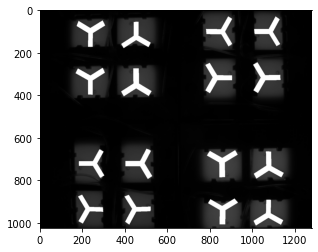

In [45]:
# load the masks
masks = np.load('mask.npz')
arm_masks = masks['arm_masks']
arm_reward_masks = masks['arm_reward_masks']

# load the background
background = io.imread('background.png')

# create a combined mask
combined_mask = np.repeat([np.int32(arm_masks.sum(axis=0)>0)*255],3,axis=0).transpose(1,2,0)

# create a combined reward mask
combined_reward_mask = np.repeat([1-0.4*np.int32(arm_reward_masks.sum(axis=0)>0)],3,axis=0).transpose(1,2,0)

# create the combined background frame
frame = background.copy()
frame[:,:,:3] = np.clip(frame[:,:,:3]+combined_mask,0,255)

# plot the combined background frame
plt.imshow(frame)

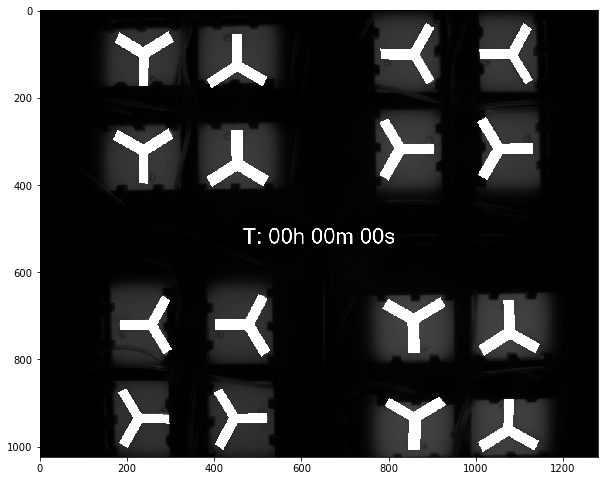

In [46]:
from PIL import Image, ImageDraw, ImageFont

font = ImageFont.truetype("arial.ttf", 50)
image = Image.new('RGBA', (frame.shape[1], frame.shape[0]), (0,0,0,255))
draw = ImageDraw.Draw(image)
tw,th = draw.textsize("T: 00h 00m 00s", font=font)
x,y = (frame.shape[1]-tw)/2, (frame.shape[0]-th)/2
draw.text((x,y), "T: 00h 00m 00s", (255,255,255), font=font)

# convert to numpy array
timestamp_image = np.array(image)

plt.figure(figsize=(10,10))
plt.imshow(np.max([timestamp_image,frame],axis=0),interpolation='none')

In [80]:
trial_numbers = []
for time,image_file in zip(timestamps,image_files):
    arenas = []
    for i in range(len(data)):
        trial_no = np.argmax(time<=np.array(data[i]['trial_end_times'])) if time < np.max(data[i]['trial_end_times']) else -1
        arenas.append(trial_no)
    trial_numbers.append(arenas)
trial_numbers = np.array(trial_numbers)
rewarded_trial = np.zeros_like(trial_numbers)[:-1,:]
for i in range(rewarded_trial.shape[1]):
    rewarded_trial[:,i] = np.array(data[i]['reward_delivered'])[np.int32(trial_numbers[:,i])][:-1] *  np.int32(np.diff(trial_numbers[:,i])!=0)
rewarded_trial = rewarded_trial.astype(np.int32)[:-1,:]

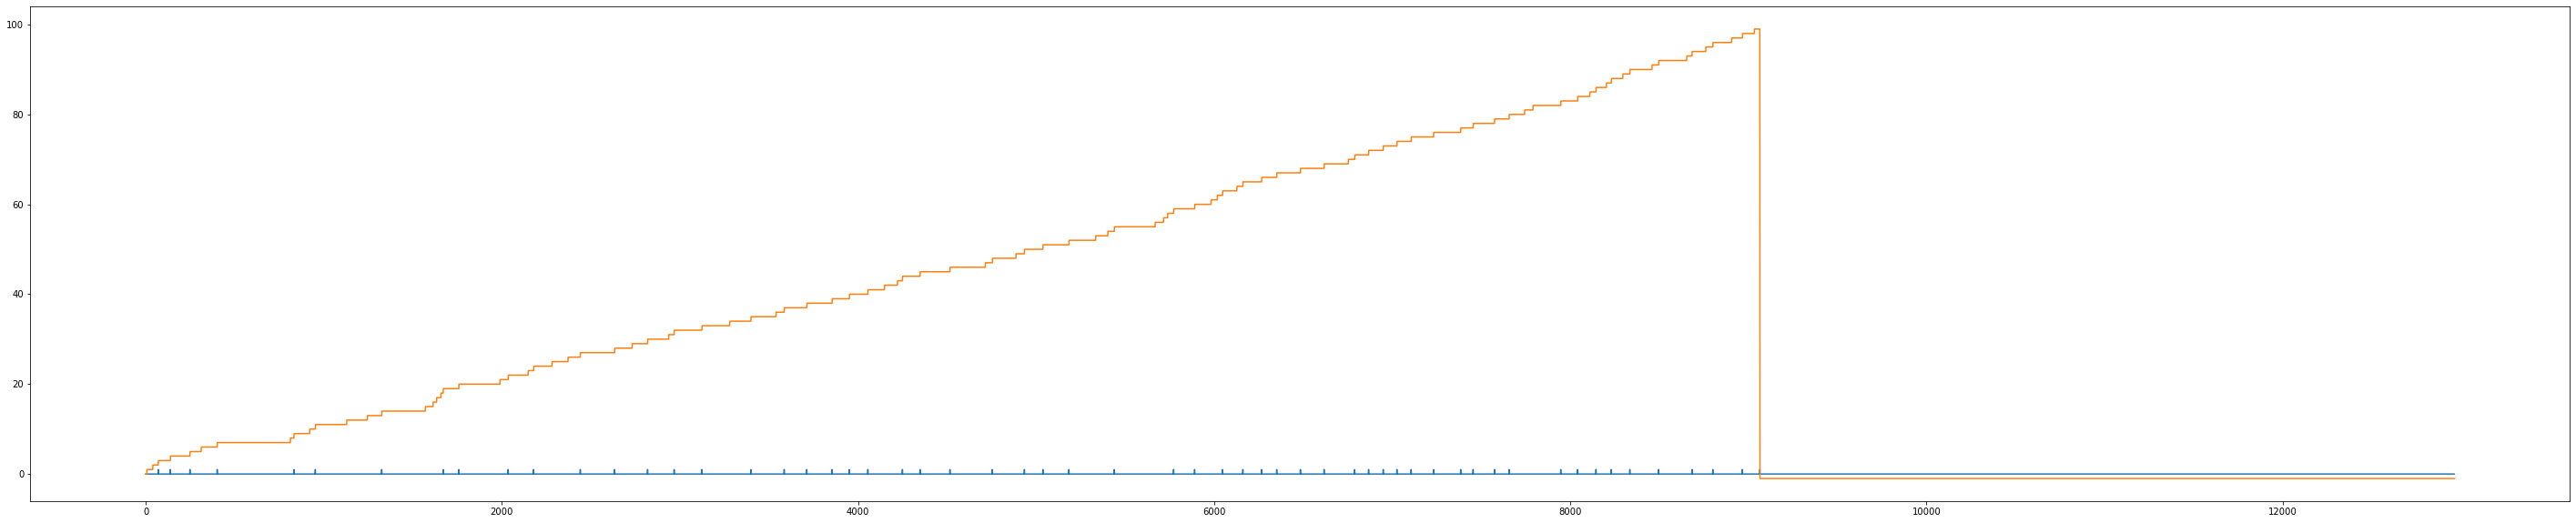

In [83]:
plt.figure(figsize=(50,10))
for i in range(13,14):
    plt.plot(rewarded_trial[:,i])
    plt.plot(trial_numbers[:,i])
# plt.xlim(9000,10000)
plt.show()

In [67]:
np.array(data[i]['reward_delivered'])[np.int32(rewarded_trial[:,i]-1)][:-1]

array([1., 1., 1., ..., 0., 0., 0.])

In [69]:
np.int32(np.diff(rewarded_trial[:,i])!=0)

array([0, 0, 0, ..., 0, 0, 1])

In [10]:
time<=np.array(data[i]['trial_end_times'])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [76]:
current_trial = [0]*len(data)
processed_images = []

for time,image_file in tqdm(zip(timestamps,image_files)):
    image = skimage.io.imread(os.path.join('video',image_file))

    # from odor vector generate the mask
    all_masks = []
    
    for i in range(len(data)):
        arm1mask = arm_masks[3*i]
        arm2mask = arm_masks[3*i+1]
        arm3mask = arm_masks[3*i+2]
        trial_no = np.argmax(time<np.array(data[i]['trial_start_times']))-1

        if trial_no > current_trial[i] and data[i]['reward_delivered'][trial_no-1] == 1.0:
            for mask in [arm1mask,arm2mask,arm3mask]:
                color_filter = np.repeat([np.repeat([[0,1,1]],mask.shape[1],axis=0)],mask.shape[0],axis=0)
                full_mask = np.repeat([np.int32(mask>0)*255],3,axis=0).transpose(1,2,0)
                colored_mask = np.clip(full_mask*color_filter,0,255)
                all_masks.append(colored_mask)
            current_trial[i] = trial_no

        else:
            if trial_no < 0:
                arm1_odor, arm2_odor, arm3_odor = 0,0,0
            else:
                arm1_odor = data[i]['odor_vectors'][trial_no][0]
                arm2_odor = data[i]['odor_vectors'][trial_no][1]
                arm3_odor = data[i]['odor_vectors'][trial_no][2]
            for mask,odor in zip([arm1mask,arm2mask,arm3mask],[arm1_odor,arm2_odor,arm3_odor]):
                if odor == 0:
                    color_filter = np.repeat([np.repeat([[0,0,0]],mask.shape[1],axis=0)],mask.shape[0],axis=0)
                elif odor == 1:
                    color_filter = np.repeat([np.repeat([[0.5,0,1]],mask.shape[1],axis=0)],mask.shape[0],axis=0)
                elif odor == 2:
                    color_filter = np.repeat([np.repeat([[0,0.5,1]],mask.shape[1],axis=0)],mask.shape[0],axis=0)
                
                full_mask = np.repeat([np.int32(mask>0)*255],3,axis=0).transpose(1,2,0)
                colored_mask = np.clip(full_mask*color_filter,0,255)
                all_masks.append(colored_mask)
            if trial_no > current_trial[i]:
                current_trial[i] = trial_no
    all_masks = np.array(all_masks)
    # combine the masks and the frame
    combined_mask = frame.copy()
    combined_mask[:,:,:3] = (frame[:,:,:3] - np.sum(all_masks,axis=0))* combined_reward_mask
    # combine with the image
    processed_image = combined_mask.copy()
    processed_image[:,:,:3] = np.int32(skimage.util.invert(image[:,:,:3])>0)*processed_image[:,:,:3]
    processed_images.append(processed_image)

579it [35:17,  3.66s/it]


In [77]:
# save the images as a video
import imageio
imageio.mimsave('video_clean.mp4',processed_images)

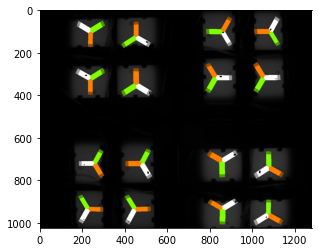

In [71]:
plt.imshow(process_image(timestamps[0],image_files[0]))

In [72]:
# parallelize the image processing using Parallel and delayed
from joblib import Parallel, delayed
import multiprocessing

processed_images = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(process_image)(time,image_file) for time,image_file in zip(timestamps,image_files))

In [52]:
np.array(data[i]['trial_start_times'])

array([1.65653323e+09, 1.65653325e+09, 1.65653327e+09, 1.65653329e+09,
       1.65653332e+09, 1.65653339e+09, 1.65653343e+09, 1.65653345e+09,
       1.65653350e+09, 1.65653353e+09])

In [85]:
# load and invert all the images
images = [io.imread(os.path.join('video',v)) for v in tqdm(image_files)]

# load the mask
mask = io.imread('mask.png')



100%|██████████| 579/579 [00:16<00:00, 35.23it/s]


In [86]:
# create a copy of the background and add the mask on a cleared region
frame = background.copy()
frame[:,:,:3] = np.clip(frame[:,:,:3]-mask[:,:,:3]*1e3,0,255) + mask[:,:,:3]

# loop over all the images
images = np.array(images)
for i in tqdm(range(len(images))):
    # invert the image
    images[i,:,:,:3] = np.int32(skimage.util.invert(images[i,:,:,:3])>0)*frame[:,:,:3]

100%|██████████| 579/579 [00:22<00:00, 25.88it/s]


In [95]:
# save the images as a video
import imageio
imageio.mimsave('video_clean.mp4',images,fps=10)

In [56]:
data_dict.keys()

dict_keys(['fly_positions', 'frame_times', 'chosen_arms', 'chosen_odor', 'reward_delivered', 'time_spent_in_reward_zone', 'lengths_of_trials', 'n_trials', 'max_frame_count', 'trial_count', 'odor_vectors', 'trial_start_times'])

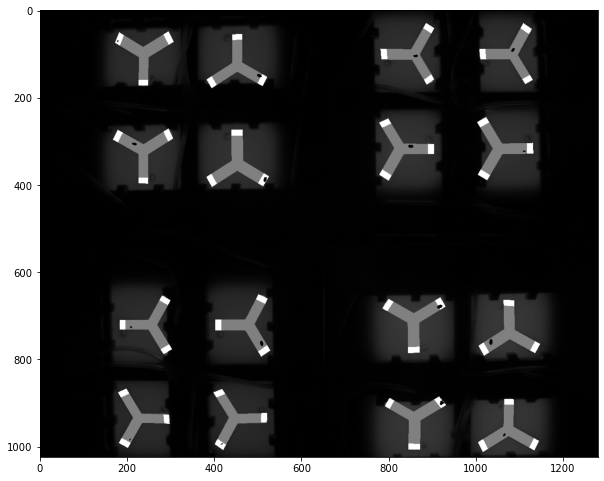

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(images[0])